In [7]:
from google.colab import files
uploaded = files.upload()




Saving lstm.csv to lstm.csv


Index(['#Passengers'], dtype='object')


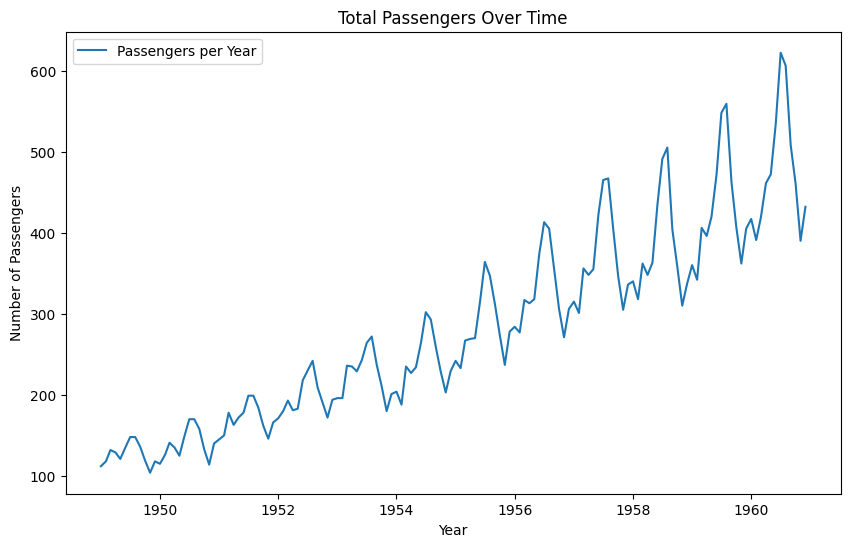

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
data = pd.read_csv('lstm.csv')
# Assuming the column containing year information is 'Month'
# Convert the 'Month' column to datetime, assuming format is Year-Month ('%Y-%m')
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index('Month', inplace=True) # Set 'Month' as index

# Print the column names to verify the change
print(data.columns)

# Extract the Passengers column
series = data['#Passengers']

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(series, label='Passengers per Year')
plt.title('Total Passengers Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Split data into train and test sets
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


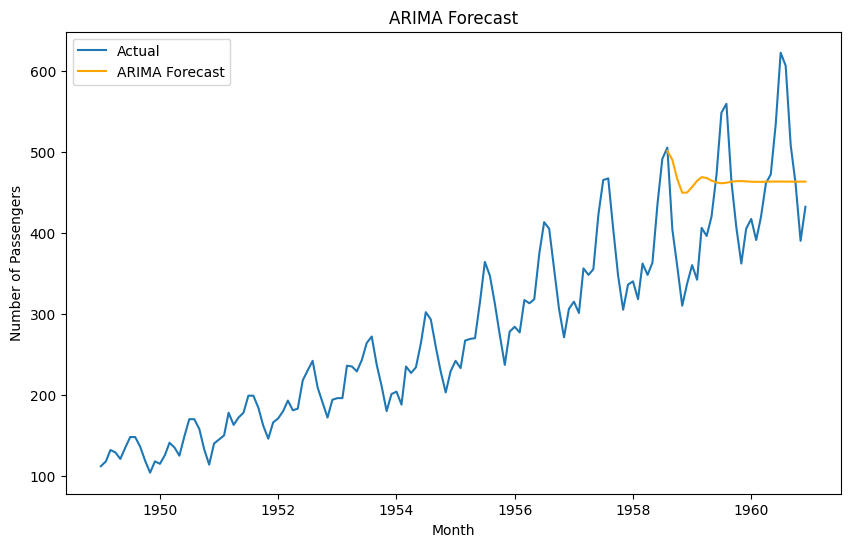

In [10]:
# ------------------ ARIMA Model ------------------
# Fit ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))  # Adjust the order as needed
arima_result = arima_model.fit()

# Forecast using ARIMA
arima_forecast = arima_result.forecast(steps=len(test))

# Plot ARIMA forecast
plt.figure(figsize=(10, 6))
plt.plot(series, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange')
plt.title('ARIMA Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0964
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0710
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0516
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0274
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0216
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0135
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0172
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0166
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0131
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0127
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0113
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0113
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0089
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0081
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━

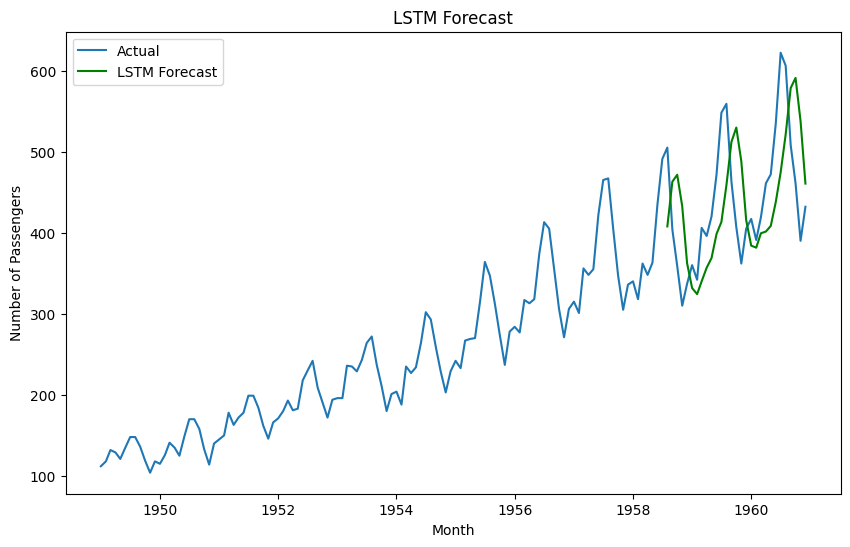

In [11]:
# ------------------ LSTM Model ------------------
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_dataset(scaled_data, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Plot LSTM forecast
plt.figure(figsize=(10, 6))
plt.plot(series, label='Actual')
plt.plot(test.index, lstm_predictions, label='LSTM Forecast', color='green')
plt.title('LSTM Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()
